# Inspect Pathology Training Data


In [5]:
import os
import sys
import itertools
import math
import logging
import json
import re
import random
import time
import concurrent.futures
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as lines
from matplotlib.patches import Polygon
import imgaug
from imgaug import augmenters as iaa

# Root directory of the project
ROOT_DIR = os.getcwd()
print(ROOT_DIR)
# if ROOT_DIR.endswith("samples/nucleus"):
if ROOT_DIR.endswith("mammography"):
    # Go up two levels to the repo root
    ROOT_DIR = os.path.dirname(ROOT_DIR)
    print(ROOT_DIR)
    
# Import Mask RCNN
sys.path.append(ROOT_DIR)
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
from mrcnn import model as modellib
from mrcnn.model import log

import mammo_baseline_pathology

%matplotlib inline 

C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography
C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN


In [3]:
# Comment out to reload imported modules if they change
%load_ext autoreload
%autoreload 2

## Configurations

In [7]:
# Dataset directory
DATASET_DIR = os.path.join(ROOT_DIR, "datasets/mammo")
    
config = mammo_baseline_pathology.MammoConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTA

[autoreload of mammo_baseline_pathology failed: Traceback (most recent call last):
  File "C:\Users\Chevy\Anaconda3\envs\nnets\lib\site-packages\IPython\extensions\autoreload.py", line 246, in check
    superreload(m, reload, self.old_objects)
  File "C:\Users\Chevy\Anaconda3\envs\nnets\lib\site-packages\IPython\extensions\autoreload.py", line 385, in superreload
    update_generic(old_obj, new_obj)
  File "C:\Users\Chevy\Anaconda3\envs\nnets\lib\site-packages\IPython\extensions\autoreload.py", line 324, in update_generic
    update(a, b)
  File "C:\Users\Chevy\Anaconda3\envs\nnets\lib\site-packages\IPython\extensions\autoreload.py", line 279, in update_class
    if old_obj == new_obj:
ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()
]


## Notebook Preferences

In [8]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Dataset
### Mass train set with pathology labelling

In [21]:
# Load dataset
subset = "mass_train"
if "3x" in subset:
    augmented=True
else:
    augmented=False

dataset = mammo_baseline_pathology.MammoDataset()
dataset.load_mammo(DATASET_DIR, subset=subset, augmented=augmented, json_filename="mammo_ddsm_mass_train.json")

# Must call before using the dataset
dataset.prepare()

print("Image Count: {}".format(len(dataset.image_ids)))
print("Class Count: {}".format(dataset.num_classes))
for i, info in enumerate(dataset.class_info):
    print("{:3}. {:50}".format(i, info['name']))




mass_train
Image Count: 983
Class Count: 3
  0. BG                                                
  1. MALIGNANT                                         
  2. BENIGN                                            


## Display Samples

(1024, 554, 1)


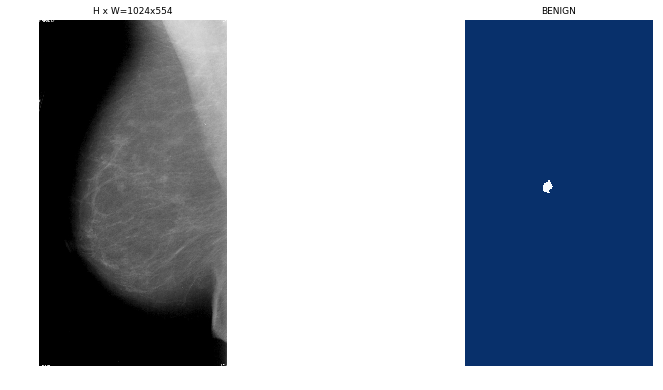

In [23]:
image_id = random.choice(dataset.image_ids)
image = dataset.load_image(image_id)
mask, class_ids = dataset.load_mask(image_id)
print(mask.shape)
visualize.display_top_masks(image, mask, class_ids, dataset.class_names, limit=1)

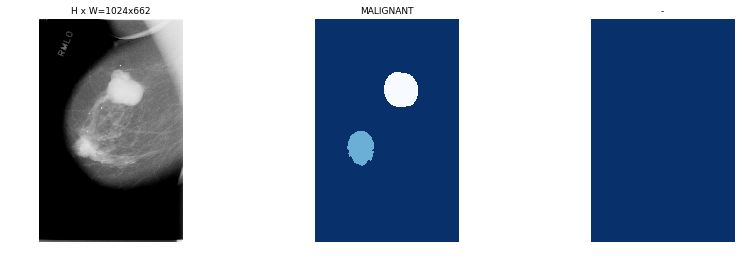

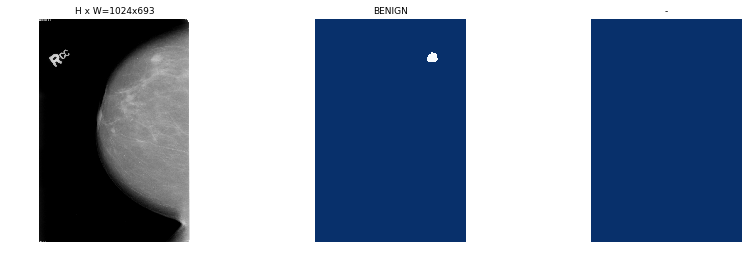

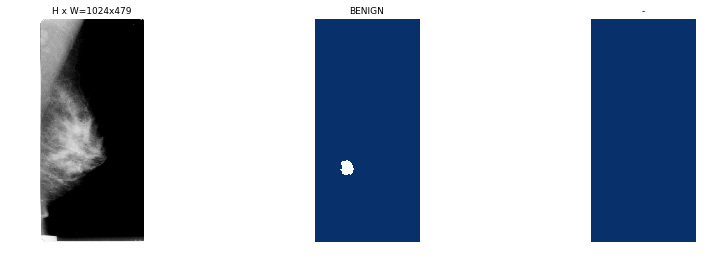

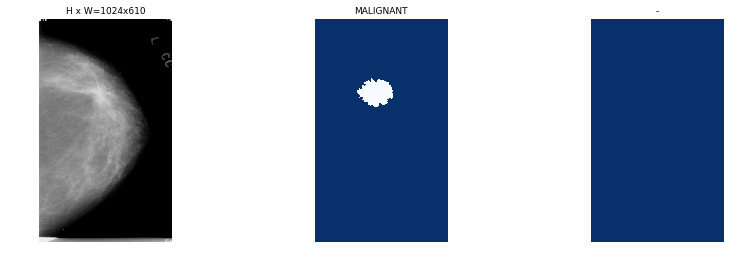

In [24]:
# Load and display random samples
image_ids = np.random.choice(dataset.image_ids, 4)

for image_id in image_ids:
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names, limit=2)

## Dataset Stats

Loop through all images in the dataset and collect aggregate stats.

In [25]:
def image_stats(image_id):
    """Returns a dict of stats for one image."""
    image = dataset.load_image(image_id)
    mask, _ = dataset.load_mask(image_id)
    bbox = utils.extract_bboxes(mask)
    # Sanity check
    assert mask.shape[:2] == image.shape[:2]
    # Return stats dict
    return {
        "id": image_id,
        "shape": list(image.shape),
        "bbox": [[b[2] - b[0], b[3] - b[1]]
                 for b in bbox
                 # Uncomment to exclude nuclei with 1 pixel width
                 # or height (often on edges)
                 # if b[2] - b[0] > 1 and b[3] - b[1] > 1
                ],
        "color": np.mean(image, axis=(0, 1)),
    }

# Loop through the dataset and compute stats over multiple threads
# This might take a few minutes
t_start = time.time()
with concurrent.futures.ThreadPoolExecutor() as e:
    stats = list(e.map(image_stats, dataset.image_ids))
t_total = time.time() - t_start
print("Total time: {:.1f} seconds".format(t_total))

Total time: 4.0 seconds


### Image Size Stats

Image Count:  983
Height  mean: 1024.00  median: 1024.00  min: 1024.00  max: 1024.00
Width   mean: 604.40  median: 607.00  min: 342.00  max: 850.00
Color   mean (RGB): 53.45 53.45 53.45


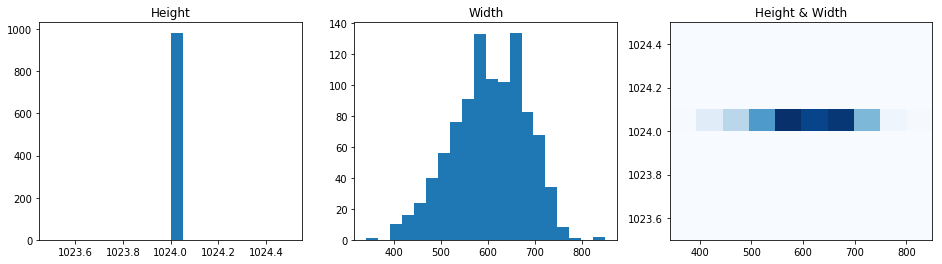

In [26]:
# Image stats
image_shape = np.array([s['shape'] for s in stats])
image_color = np.array([s['color'] for s in stats])
print("Image Count: ", image_shape.shape[0])
print("Height  mean: {:.2f}  median: {:.2f}  min: {:.2f}  max: {:.2f}".format(
    np.mean(image_shape[:, 0]), np.median(image_shape[:, 0]),
    np.min(image_shape[:, 0]), np.max(image_shape[:, 0])))
print("Width   mean: {:.2f}  median: {:.2f}  min: {:.2f}  max: {:.2f}".format(
    np.mean(image_shape[:, 1]), np.median(image_shape[:, 1]),
    np.min(image_shape[:, 1]), np.max(image_shape[:, 1])))
print("Color   mean (RGB): {:.2f} {:.2f} {:.2f}".format(*np.mean(image_color, axis=0)))

# Histograms
fig, ax = plt.subplots(1, 3, figsize=(16, 4))
ax[0].set_title("Height")
_ = ax[0].hist(image_shape[:, 0], bins=20)
ax[1].set_title("Width")
_ = ax[1].hist(image_shape[:, 1], bins=20)
ax[2].set_title("Height & Width")
_ = ax[2].hist2d(image_shape[:, 1], image_shape[:, 0], bins=10, cmap="Blues")